In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, Lasso, RidgeCV, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')


In [5]:
train = pd.read_excel("Data_Train.xlsx")
test = pd.read_excel("Test_set.xlsx")

In [6]:
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [7]:
test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [8]:
print("Training Dataset Shape:", train.shape)
print("Test Dataset Shape:", test.shape)

Training Dataset Shape: (10683, 11)
Test Dataset Shape: (2671, 10)


In [9]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB


In [11]:
train.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [12]:
train.isna().sum()

,0
Airline,0
Date_of_Journey,0
Source,0
Destination,0
Route,1
Dep_Time,0
Arrival_Time,0
Duration,0
Total_Stops,1
Additional_Info,0


In [13]:
test.isna().sum()

,0
Airline,0
Date_of_Journey,0
Source,0
Destination,0
Route,0
Dep_Time,0
Arrival_Time,0
Duration,0
Total_Stops,0
Additional_Info,0


In [14]:
train.duplicated().sum()

np.int64(220)

In [15]:
train.drop_duplicates(inplace=True)

In [16]:
train.isnull().sum()

,0
Airline,0
Date_of_Journey,0
Source,0
Destination,0
Route,1
Dep_Time,0
Arrival_Time,0
Duration,0
Total_Stops,1
Additional_Info,0


In [17]:
train[train.isnull().any(axis=1)]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [18]:
train.dropna(inplace=True)

In [19]:
print('Observing the airline column:')
train['Airline'].value_counts()

Observing the airline column:


,count
Airline,
Jet Airways,3700
IndiGo,2043
Air India,1694
Multiple carriers,1196
SpiceJet,815
Vistara,478
Air Asia,319
GoAir,194
Multiple carriers Premium economy,13


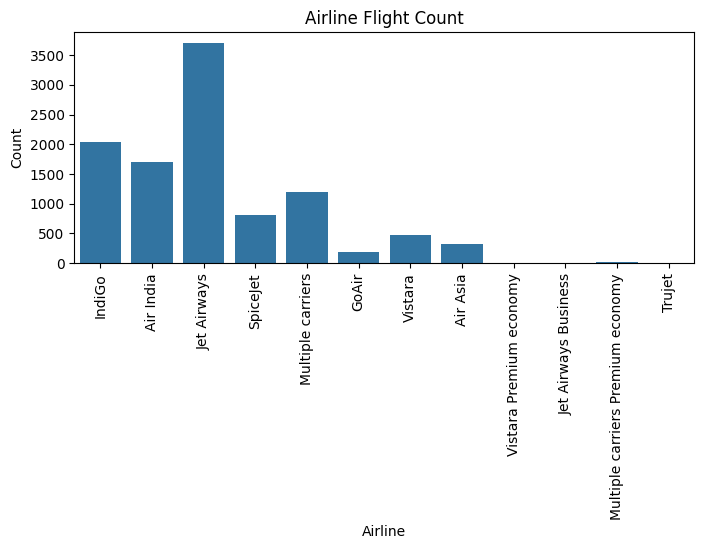

In [20]:
plt.figure(figsize=(8,3))
sns.countplot(x='Airline', data=train)
plt.title('Airline Flight Count')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Observing the Price column for each airline: 


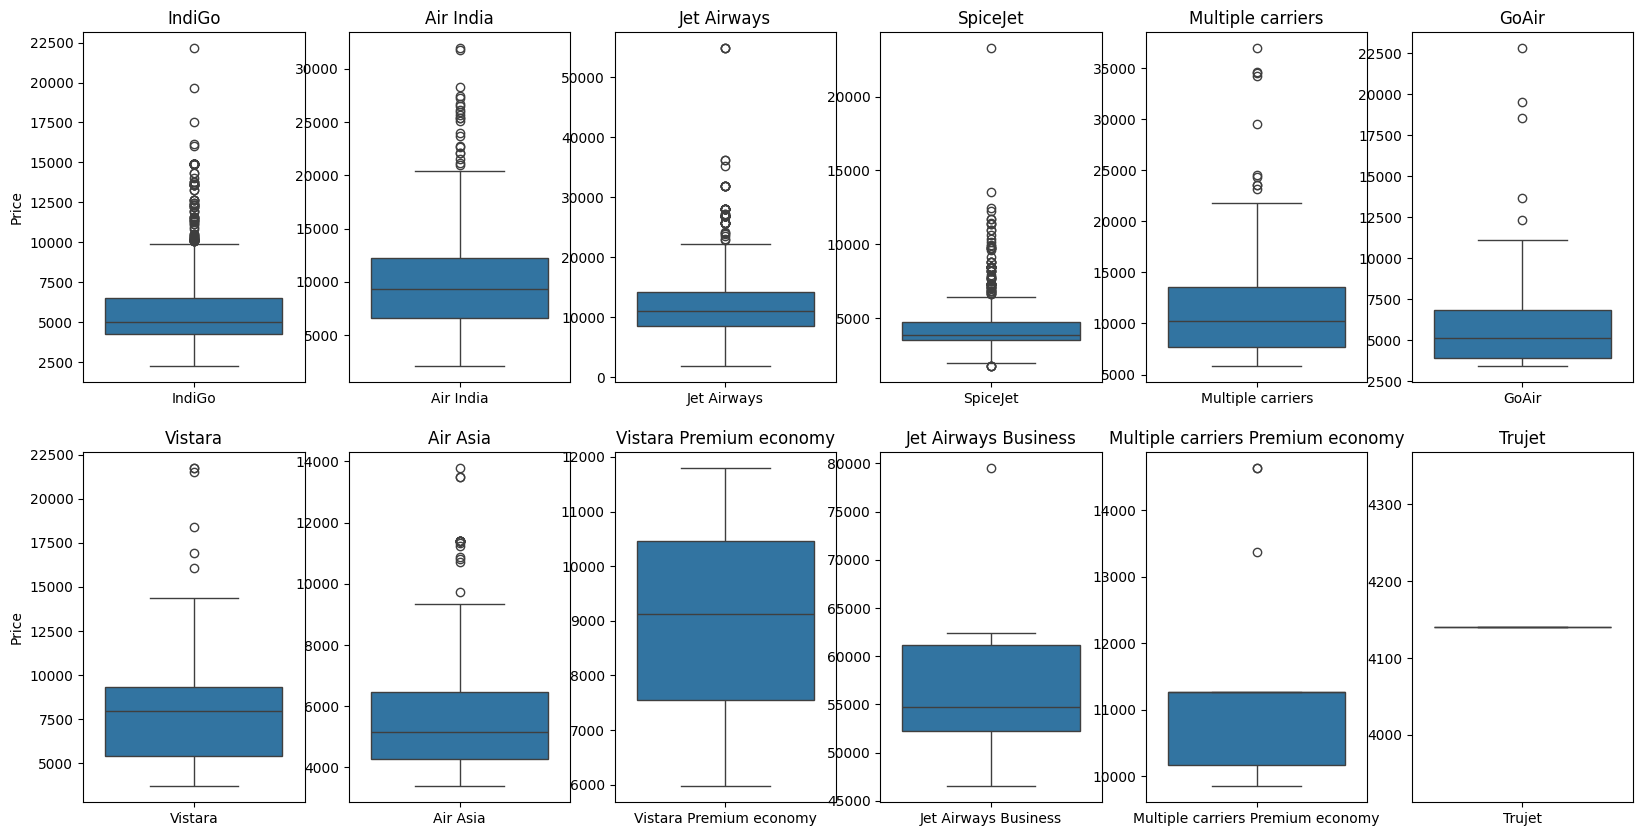

In [21]:
print('Observing the Price column for each airline: ')
unique_airlines = train['Airline'].unique()
n = 6
num_rows = int(np.ceil(len(unique_airlines) / n))

plt.figure(figsize=(20, 5 * num_rows))

for i, airline in enumerate(unique_airlines):
    plt.subplot(num_rows, n, i + 1)
    sns.boxplot(data=train[train['Airline'] == airline], x='Airline', y='Price')
    plt.title(airline)
    plt.xlabel('')
    plt.ylabel('Price' if i % n == 0 else '')
plt.show()

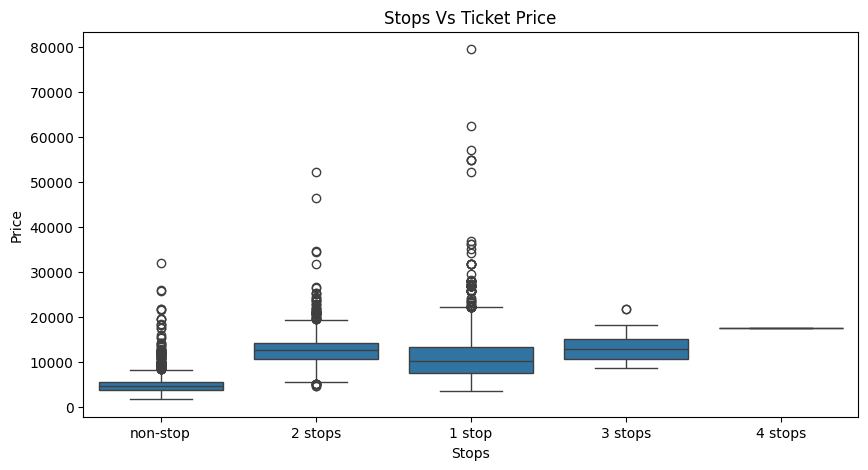

In [22]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Total_Stops', y='Price', data=train)
plt.title('Stops Vs Ticket Price')
plt.xlabel('Stops')
plt.ylabel('Price')
plt.show()

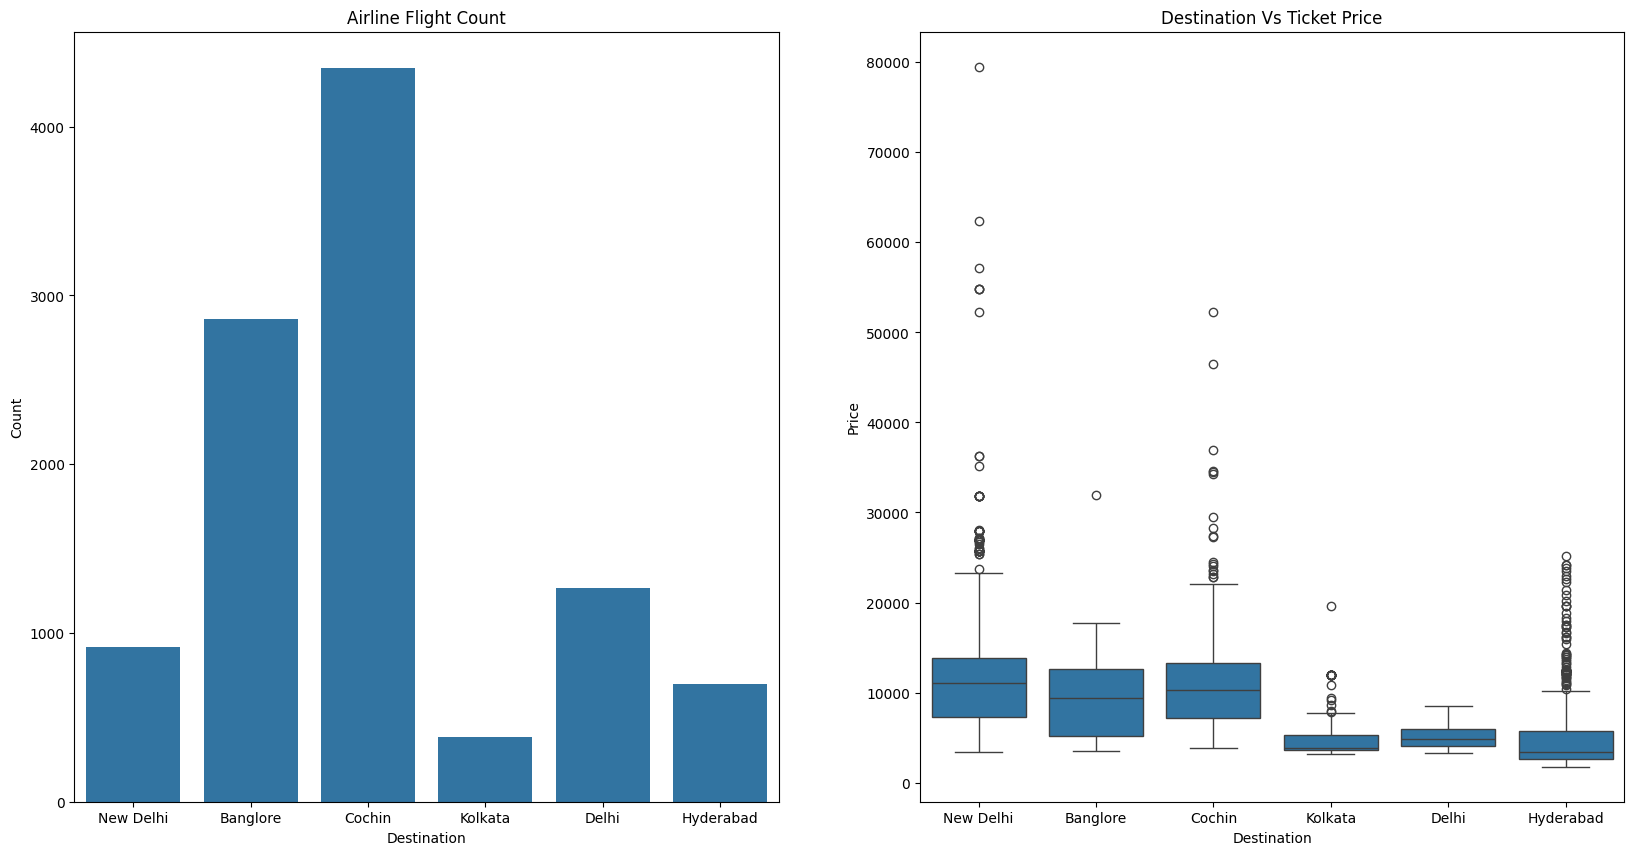

In [23]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.countplot(x='Destination', data=train)
plt.title('Airline Flight Count')
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.boxplot(x='Destination', y='Price', data=train)
plt.title('Destination Vs Ticket Price')
plt.xlabel('Destination')
plt.ylabel('Price')

plt.show()

In [24]:
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [25]:
#### Date of Journey
df = pd.DataFrame(train)

In [26]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [27]:
df["Date_of_Journey"] = pd.to_datetime(df["Date_of_Journey"])

In [28]:
df["Journey_Day"] = df["Date_of_Journey"].dt.day

In [29]:
df["Journey_Month"] = df["Date_of_Journey"].dt.month

In [30]:
df["Journey_DOW"] = df["Date_of_Journey"].dt.dayofweek

In [31]:
df.drop("Date_of_Journey", axis=1, inplace=True)

0.0.4 Departure Time

In [32]:
df["Dep_Hour"] = pd.to_datetime(df["Dep_Time"]).dt.hour

In [33]:
df["Dep_Minute"] = pd.to_datetime(df["Dep_Time"]).dt.minute

In [34]:
df.drop("Dep_Time", axis=1, inplace=True)

**Arrival Time**

In [35]:
df["Arrival_Hour"] = pd.to_datetime(df["Arrival_Time"]).dt.hour
df["Arrival_Minute"] = pd.to_datetime(df["Arrival_Time"]).dt.minute
df.drop("Arrival_Time", axis=1, inplace=True)

**Duration**

In [36]:
df["Duration"] = df["Duration"].str.replace('h','*60').str.replace(' ','+').str.replace('m','*1').apply(eval)

**Total Stops**

In [37]:
df.Total_Stops.value_counts()

,count
Total_Stops,
1 stop,5625
non-stop,3475
2 stops,1318
3 stops,43
4 stops,1


In [38]:
df["Total_Stops"] = df["Total_Stops"].replace({
    "non-stop": 0,
    "1 stop": 1,
    "2 stops": 2,
    "3 stops": 3,
    "4 stops": 4
})

**Additional Information**

In [39]:
df.Additional_Info.value_counts()

,count
Additional_Info,
No info,8182
In-flight meal not included,1926
No check-in baggage included,318
1 Long layover,19
Change airports,7
Business class,4
No Info,3
1 Short layover,1
Red-eye flight,1


In [40]:
#df.drop(columns='Additional_Info', axis=1, inplace=True)
df.Additional_Info = df.Additional_Info.map({
    'No info':8,
    'No Info':8,
    'In-flight meal not included':7,
    'No check-in baggage included':6,
    '1 Long layover':5,
    'Change airports':4,
    'Business class':3,
    '1 Short layover':2,
    'Red-eye flight':1,
    '2 Long layover':0
})

In [41]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [42]:
df["Airline"].value_counts().sort_index()

,count
Airline,
Air Asia,319
Air India,1694
GoAir,194
IndiGo,2043
Jet Airways,3700
Jet Airways Business,6
Multiple carriers,1196
Multiple carriers Premium economy,13
SpiceJet,815


In [43]:
df["Airline"] = le.fit_transform(df["Airline"])

**Source and Destination**

In [44]:
df["Source"].value_counts().sort_index()

,count
Source,
Banglore,2179
Chennai,381
Delhi,4345
Kolkata,2860
Mumbai,697


In [45]:
df["Destination"] = le.fit_transform(df["Destination"])

In [46]:
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Journey_DOW,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute
0,3,Banglore,5,BLR → DEL,170,0,8,3897,24,3,6,22,20,1,10
1,1,Kolkata,0,CCU → IXR → BBI → BLR,445,2,8,7662,1,5,2,5,50,13,15
2,4,Delhi,1,DEL → LKO → BOM → COK,1140,2,8,13882,9,6,6,9,25,4,25
3,3,Kolkata,0,CCU → NAG → BLR,325,1,8,6218,12,5,6,18,5,23,30
4,3,Banglore,5,BLR → NAG → DEL,285,1,8,13302,1,3,4,16,50,21,35


**0.0.6 EDA Analysis**
**Univarat Analysis**

<Axes: xlabel='Journey_DOW', ylabel='count'>

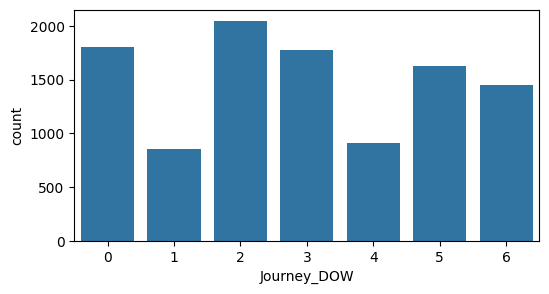

In [47]:
plt.figure(figsize=(6,3))
sns.countplot(x='Journey_DOW', data=df)

<Axes: xlabel='Journey_Month', ylabel='count'>

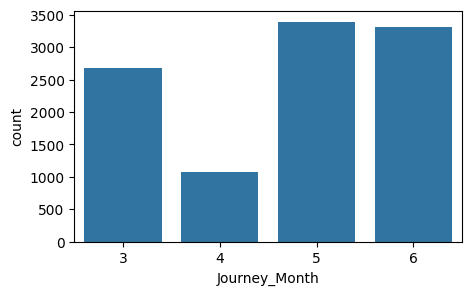

In [48]:
plt.figure(figsize=(5,3))
sns.countplot(x="Journey_Month", data=df)

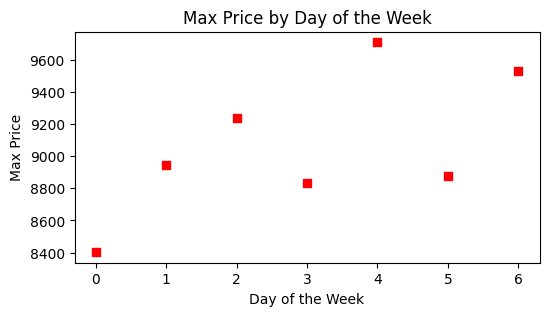

In [49]:
max_prices = df.groupby("Journey_DOW")["Price"].mean()
plt.figure(figsize=(6,3))
plt.scatter(max_prices.index, max_prices.values, color='r', marker='s')
plt.xlabel('Day of the Week')
plt.ylabel('Max Price')
plt.title('Max Price by Day of the Week')
plt.show()

<Axes: xlabel='Total_Stops', ylabel='count'>

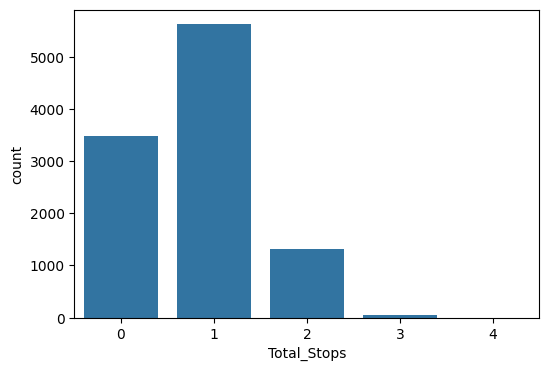

In [50]:
plt.figure(figsize=(6,4))
sns.countplot(x="Total_Stops", data=df)

<Axes: xlabel='Destination', ylabel='count'>

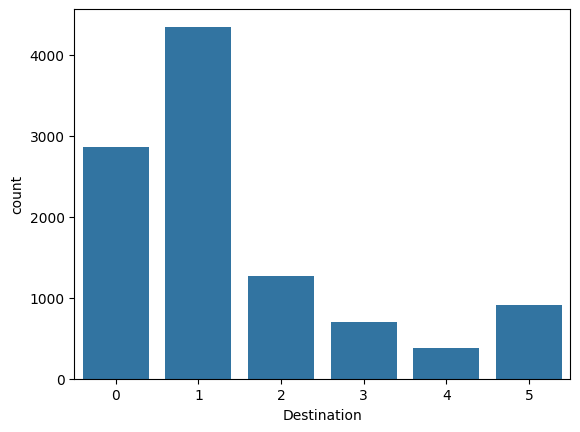

In [51]:
sns.countplot(x="Destination", data=df)

<Axes: xlabel='Duration', ylabel='Count'>

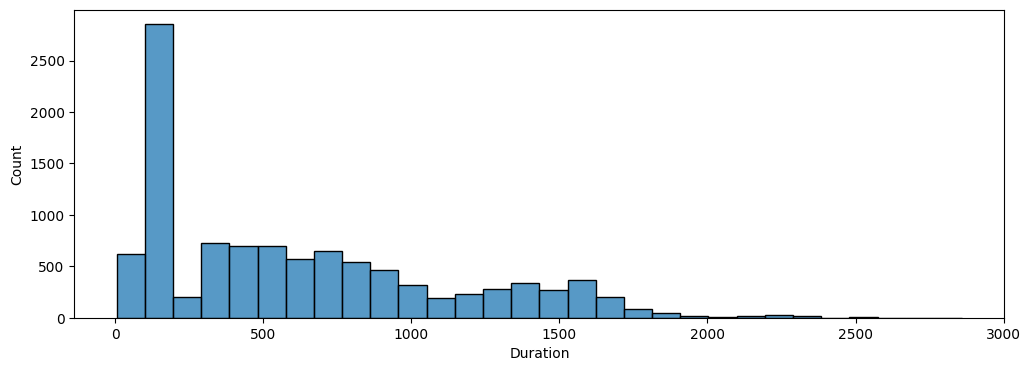

In [52]:
plt.figure(figsize=(12,4))
sns.histplot(data=df, x="Duration", bins=30)

<Axes: xlabel='Arrival_Hour', ylabel='Count'>

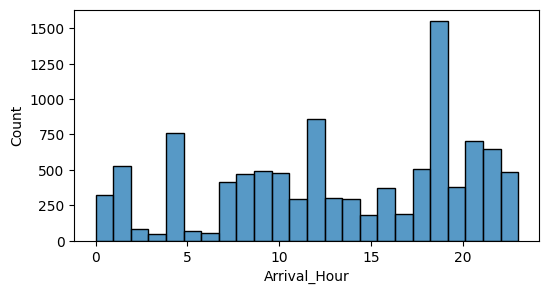

In [53]:
plt.figure(figsize=(6,3))
sns.histplot(data=df, x="Arrival_Hour", bins=24)

<Axes: xlabel='Dep_Hour', ylabel='Count'>

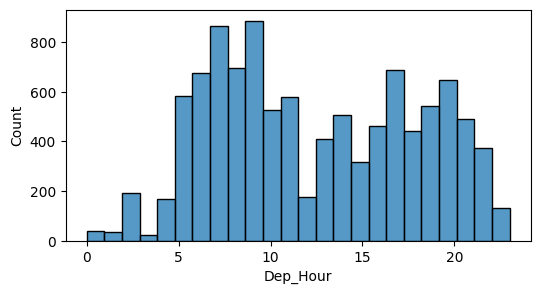

In [54]:
plt.figure(figsize=(6,3))
sns.histplot(data=df, x="Dep_Hour", bins=24)

<Axes: xlabel='Price', ylabel='Count'>

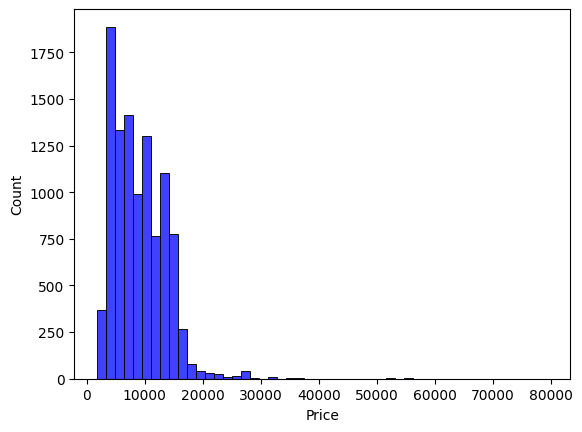

In [55]:
sns.histplot(data=df, x="Price", bins=50, color='blue')

**0.0.7 Bivariate Analysis**

<Axes: xlabel='Duration', ylabel='Price'>

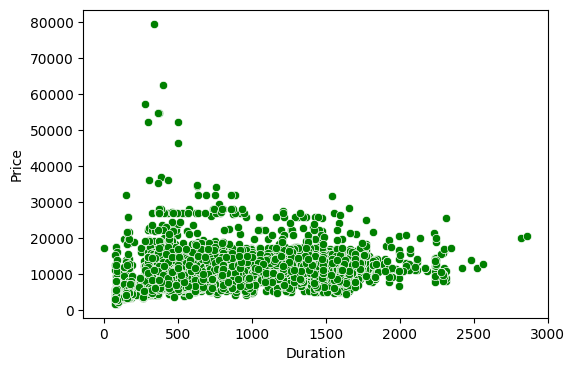

In [56]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="Duration", y="Price", color="green", marker="o")

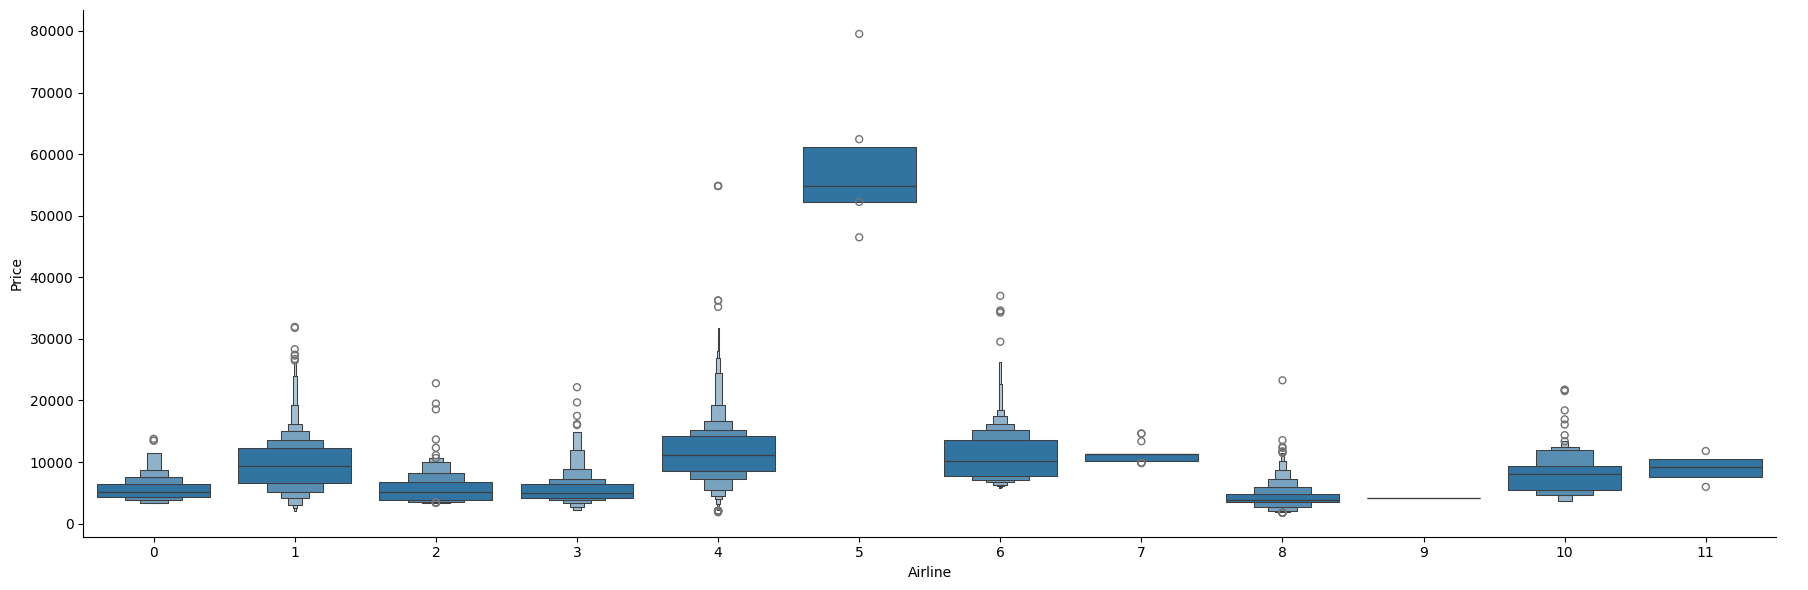

In [57]:
sns.catplot(y="Price", x="Airline", data=df.sort_values("Price", ascending=False),
            kind="boxen", height=6, aspect=3)
plt.show()

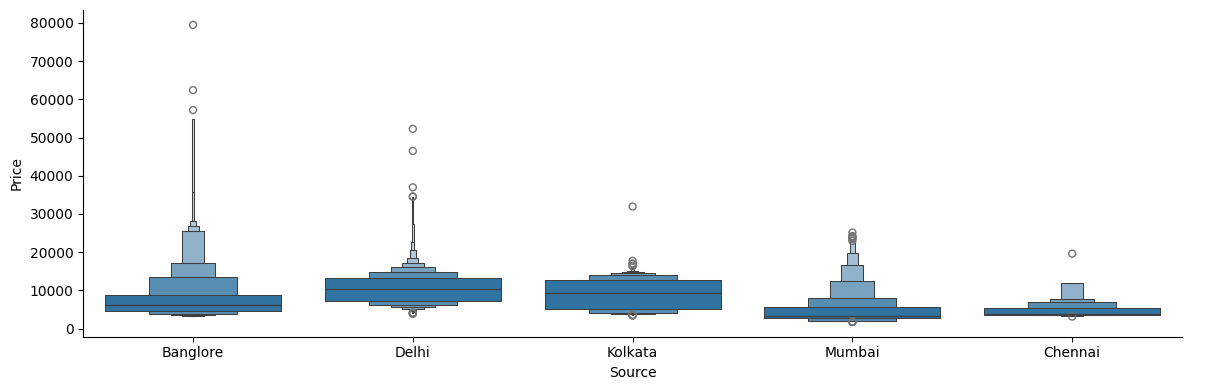

In [58]:
sns.catplot(y="Price", x="Source", data=df.sort_values("Price", ascending=False),
            kind="boxen", height=4, aspect=3)
plt.show()

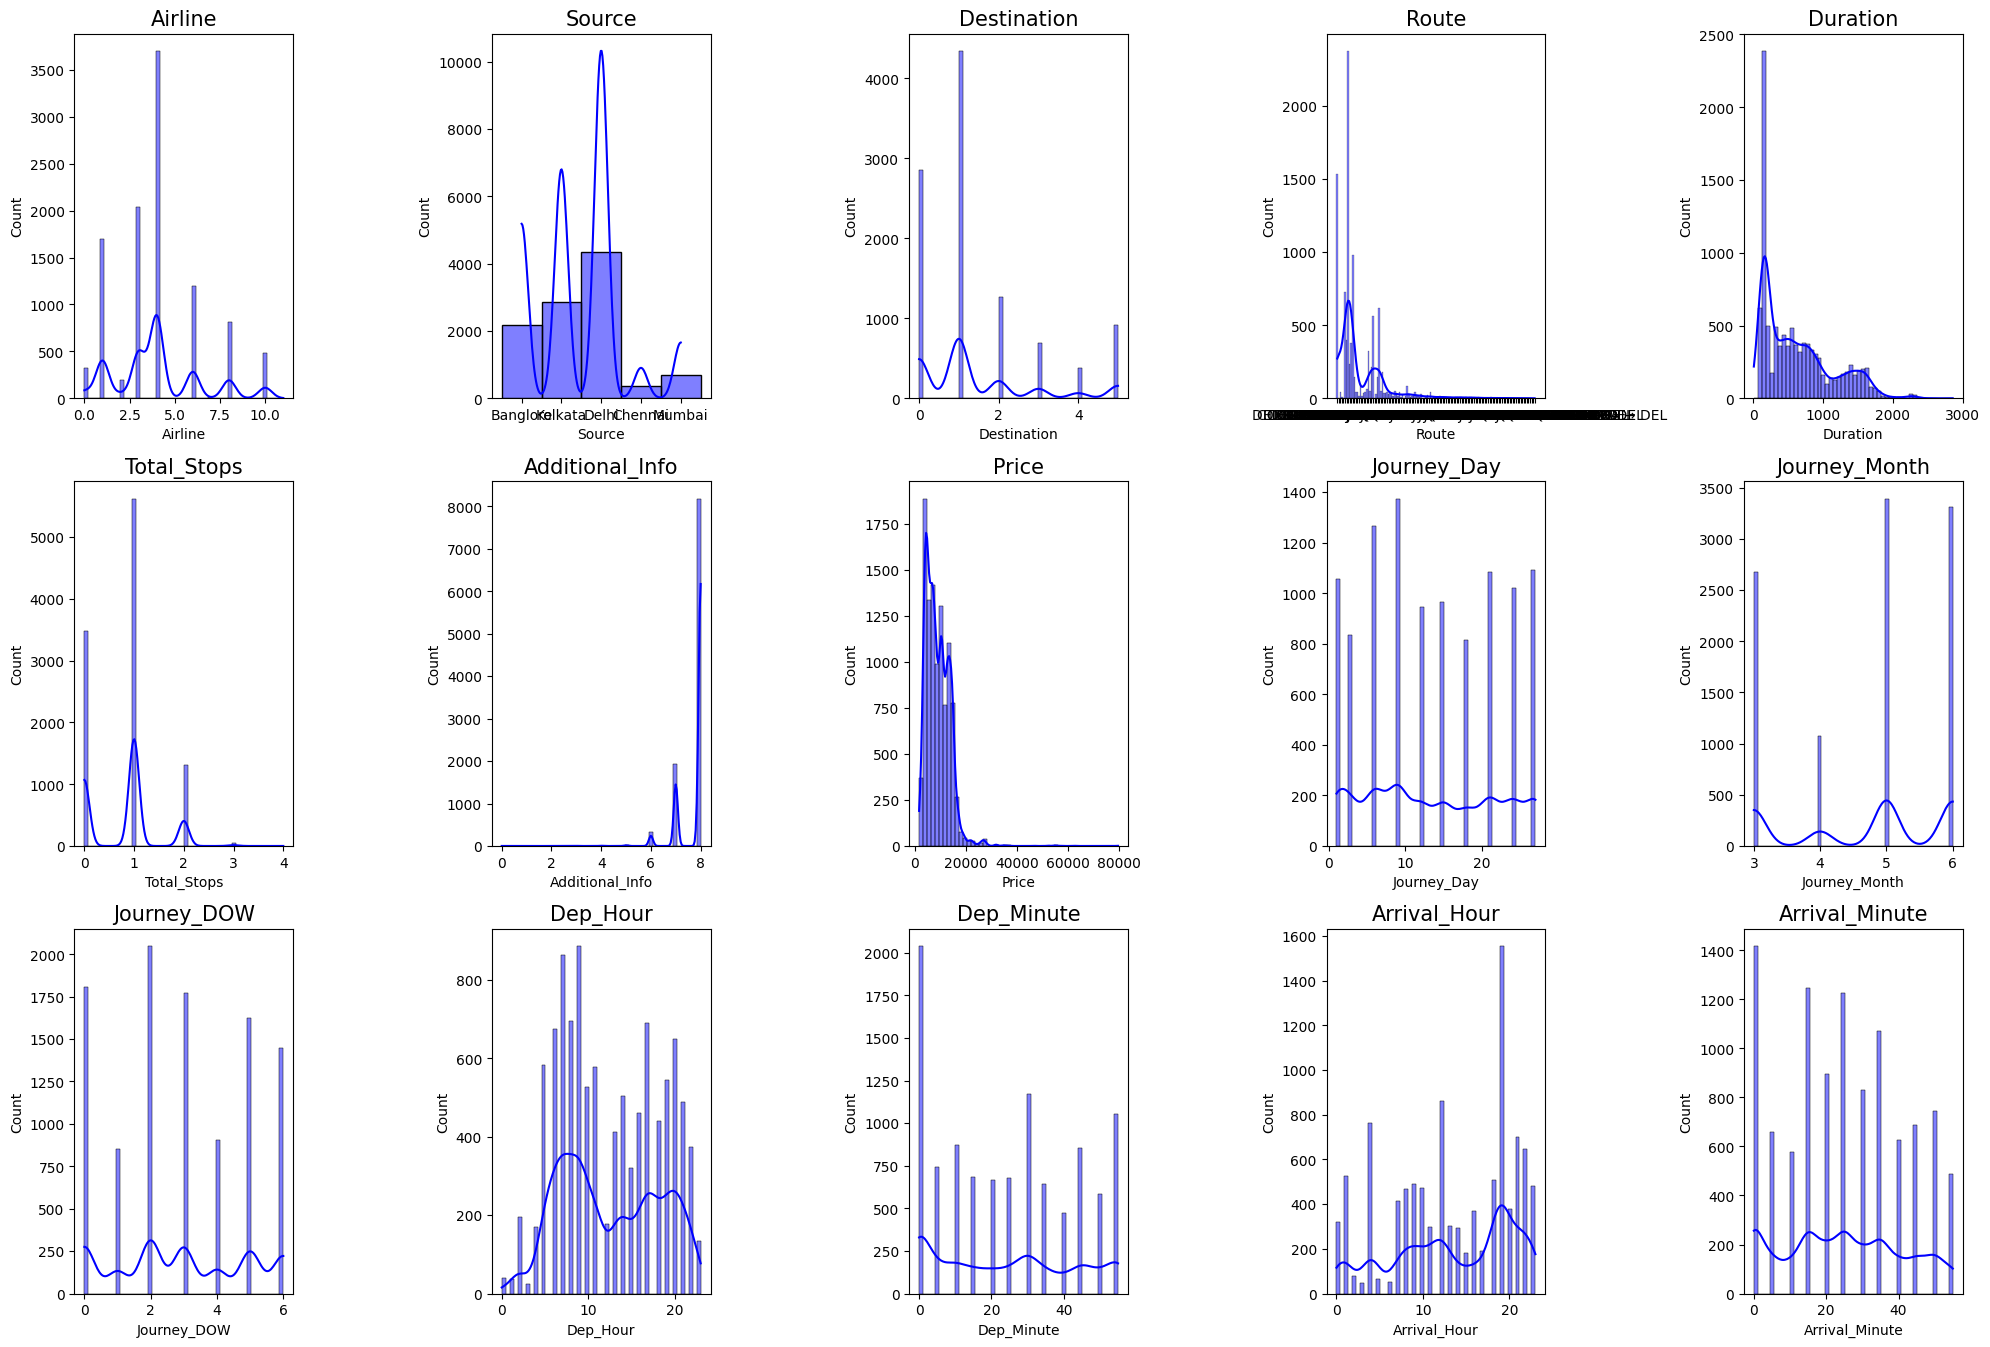

In [59]:
plt.figure(figsize=(20, 40))
plotnumber = 1

for column in df.columns:
    if plotnumber <= 40:
        plt.subplot(9, 5, plotnumber)
        sns.histplot(df[column], bins=50, kde=True, color='blue')
        plt.title(f'{column}', fontsize=15)
        plotnumber += 1

plt.tight_layout()
plt.show()

In [60]:
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Journey_DOW,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute
0,3,Banglore,5,BLR → DEL,170,0,8,3897,24,3,6,22,20,1,10
1,1,Kolkata,0,CCU → IXR → BBI → BLR,445,2,8,7662,1,5,2,5,50,13,15
2,4,Delhi,1,DEL → LKO → BOM → COK,1140,2,8,13882,9,6,6,9,25,4,25
3,3,Kolkata,0,CCU → NAG → BLR,325,1,8,6218,12,5,6,18,5,23,30
4,3,Banglore,5,BLR → NAG → DEL,285,1,8,13302,1,3,4,16,50,21,35


**Multivariate Analysis**

In [61]:
# Filter numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns

# Calculate correlation with Price
price_correlation = df[numeric_columns].corr()["Price"]
print(price_correlation)

Airline           -0.036491
Destination       -0.065875
Duration           0.501758
Total_Stops        0.602013
Additional_Info    0.017603
Price              1.000000
Journey_Day       -0.159044
Journey_Month     -0.113396
Journey_DOW        0.055846
Dep_Hour           0.005155
Dep_Minute        -0.024155
Arrival_Hour       0.031023
Arrival_Minute    -0.086163
Name: Price, dtype: float64


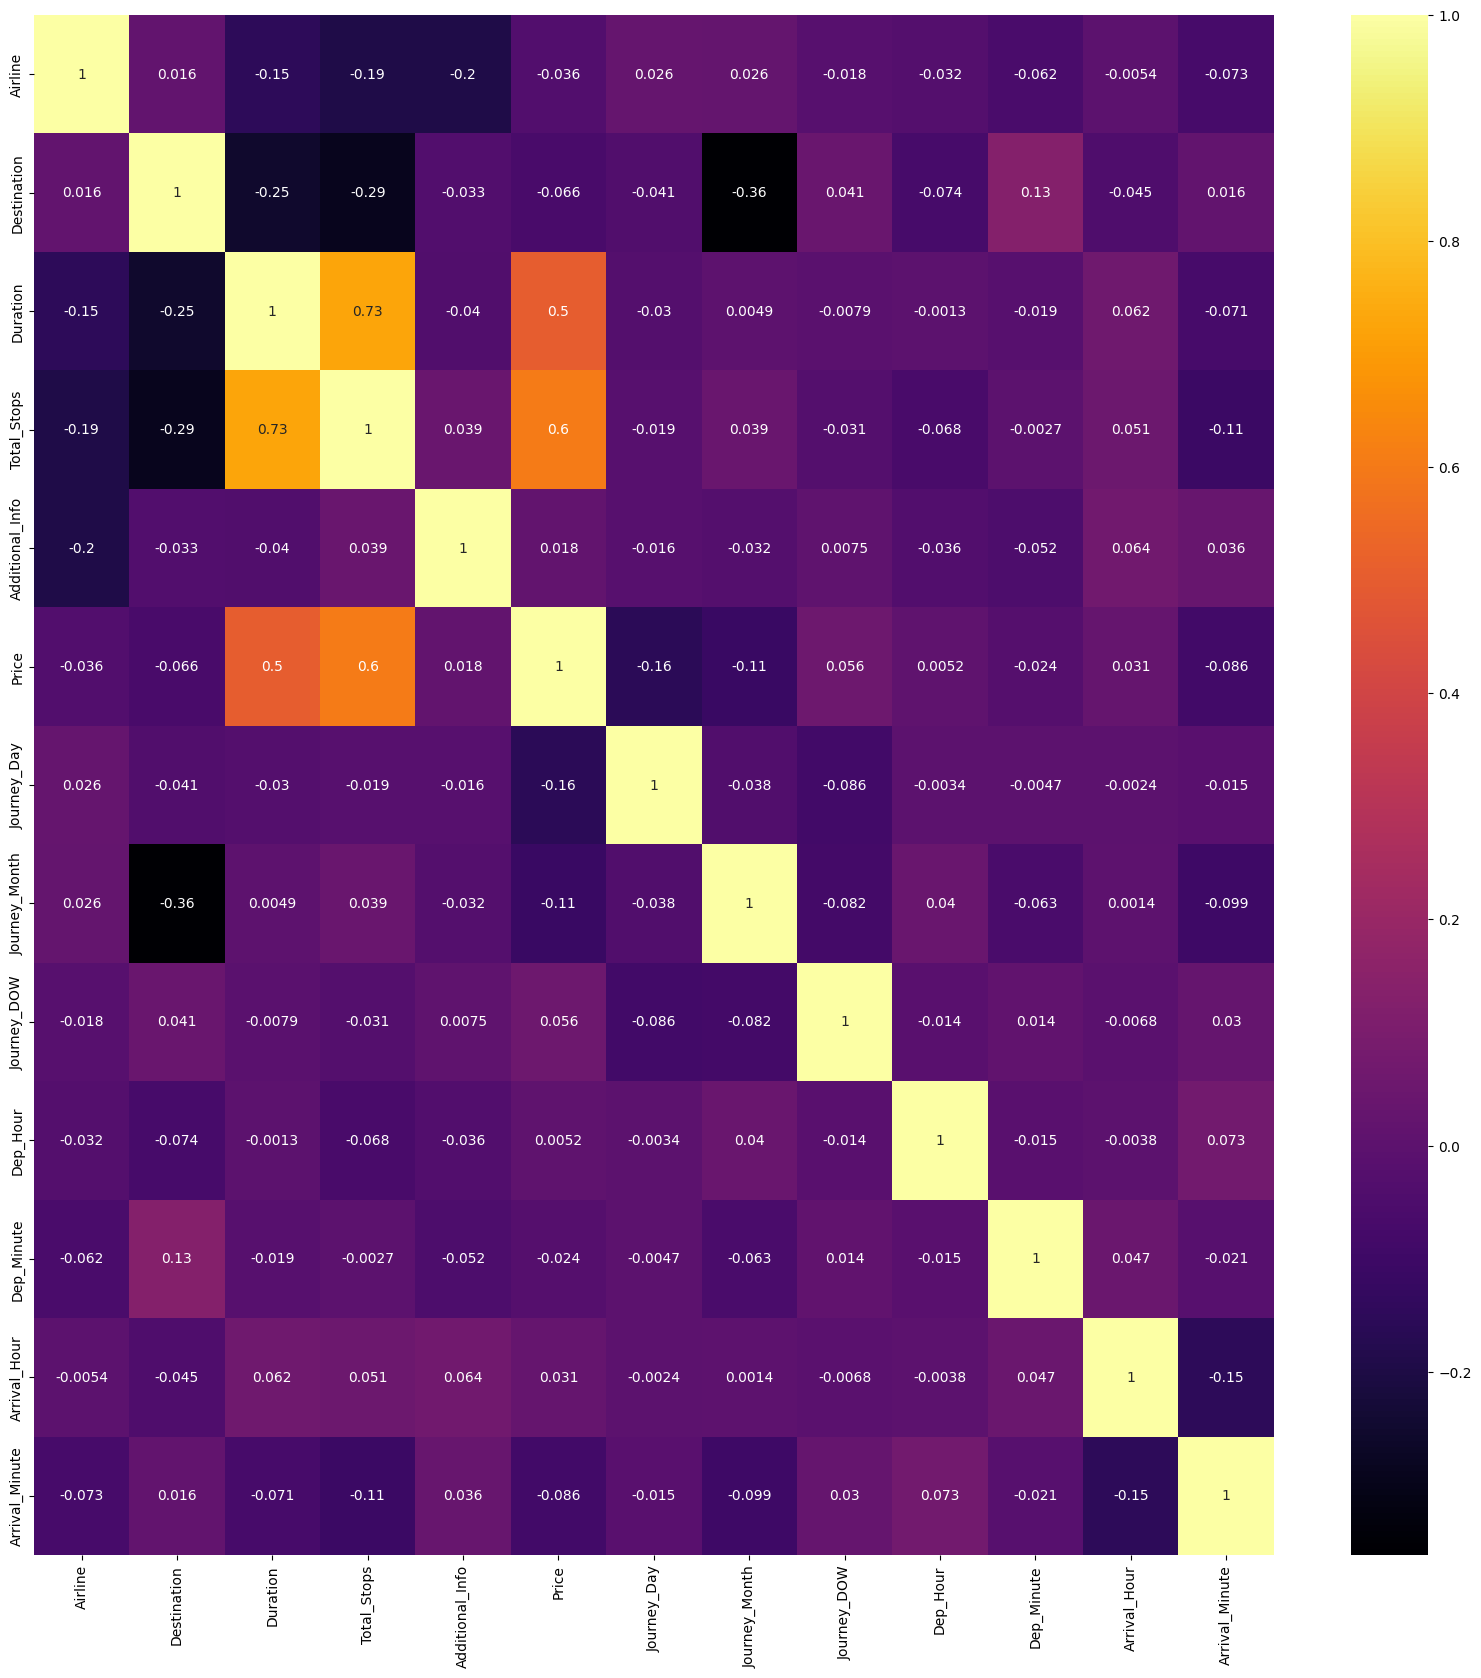

In [62]:
# Heatmap for correlation
numeric_columns = df.select_dtypes(include=['number']).columns

plt.figure(figsize=(20, 20))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap="inferno")
plt.show()

**0.0.9 Feature Engineering**

In [63]:
def classify_flight_time(time_str):
    time = datetime.strptime(time_str, '%H:%M').time()

    if time >= datetime.strptime('00:00', '%H:%M').time() and time < datetime.strptime('06:00', '%H:%M').time():
        return 'Early Morning'

    elif time >= datetime.strptime('06:00', '%H:%M').time() and time < datetime.strptime('12:00', '%H:%M').time():
        return 'Morning'

    elif time >= datetime.strptime('12:00', '%H:%M').time() and time < datetime.strptime('18:00', '%H:%M').time():
        return 'Afternoon'

    elif time >= datetime.strptime('18:00', '%H:%M').time() and time < datetime.strptime('22:00', '%H:%M').time():
        return 'Evening'

    else:
        return 'Late Night'


train['Departure'] = train['Dep_Time'].apply(classify_flight_time)
test['Departure'] = test['Dep_Time'].apply(classify_flight_time)

In [64]:
def calculate_arrival(departure, duration):
    departure_time = datetime.strptime(departure, "%H:%M")

    if 'h' in duration:
        parts = duration.split('h')
        hours = int(parts[0]) if parts[0] else 0
        minutes = int(parts[1].strip().replace('m','')) if parts[1] else 0
    else:
        hours = 0
        minutes = int(duration.replace('m',''))

    arrival_time = departure_time + timedelta(hours=hours, minutes=minutes)
    return arrival_time.strftime("%H:%M")


train['Arr_Time'] = train.apply(lambda row: calculate_arrival(row['Dep_Time'], row['Duration']), axis=1)
train['Arrival'] = train['Arr_Time'].apply(classify_flight_time)

test['Arr_Time'] = test.apply(lambda row: calculate_arrival(row['Dep_Time'], row['Duration']), axis=1)
test['Arrival'] = test['Arr_Time'].apply(classify_flight_time)

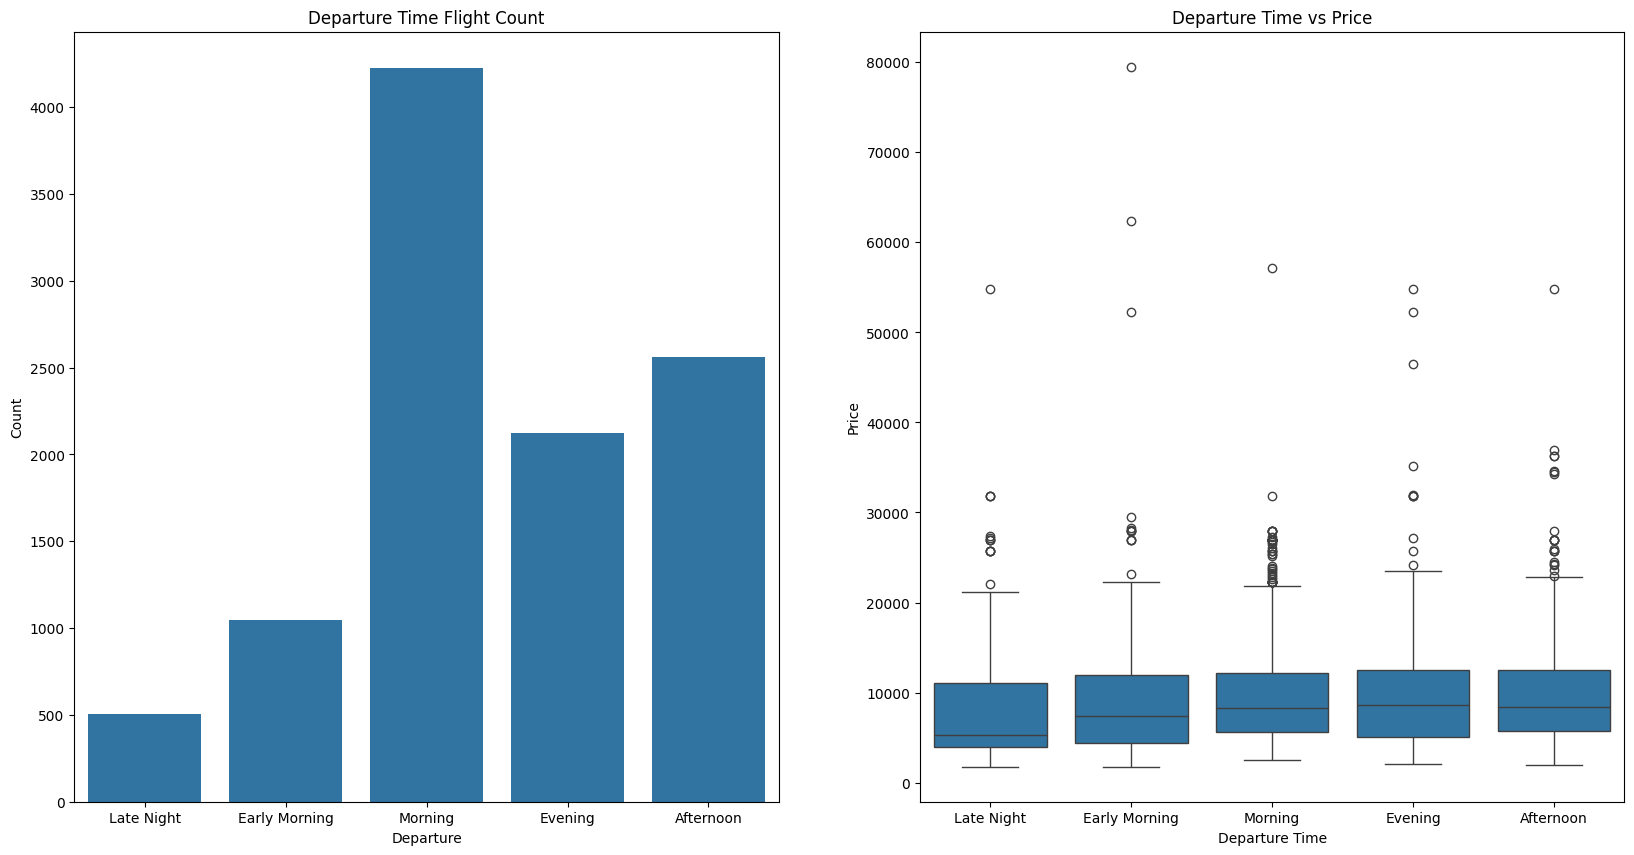

In [65]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.countplot(x='Departure', data=train)
plt.title('Departure Time Flight Count')
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.boxplot(x='Departure', y='Price', data=train)
plt.title('Departure Time vs Price')
plt.xlabel('Departure Time')
plt.ylabel('Price')

plt.show()

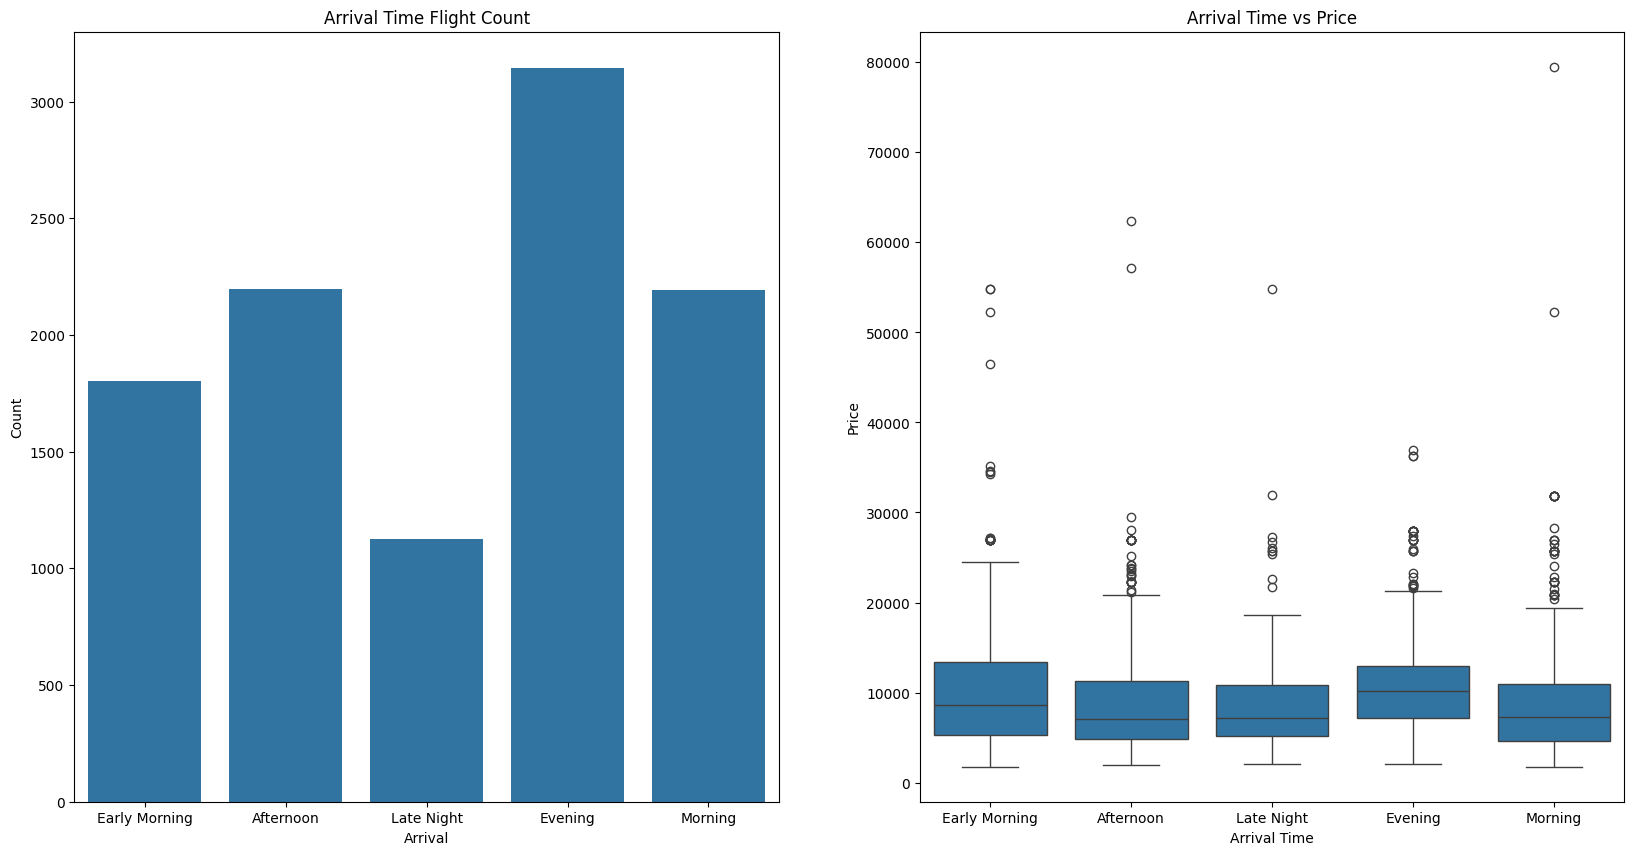

In [66]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.countplot(x='Arrival', data=train)
plt.title('Arrival Time Flight Count')
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.boxplot(x='Arrival', y='Price', data=train)
plt.title('Arrival Time vs Price')
plt.xlabel('Arrival Time')
plt.ylabel('Price')

plt.show()

In [67]:
train['Date'] = pd.to_datetime(train['Date_of_Journey'], format='%d/%m/%Y')
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['Year'] = train['Date'].dt.year

test['Date'] = pd.to_datetime(test['Date_of_Journey'], format='%d/%m/%Y')
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day
test['Year'] = test['Date'].dt.year

In [68]:
train['Year'].value_counts()

,count
Year,
2019,10462


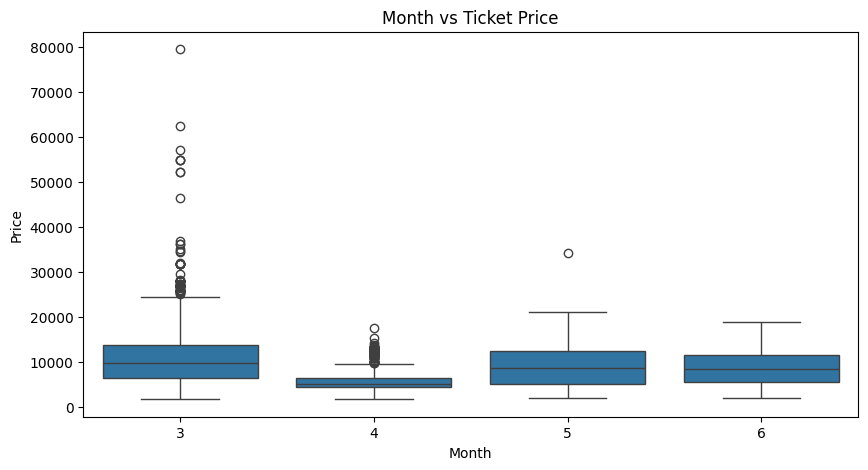

In [69]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Month', y='Price', data=train)
plt.title('Month vs Ticket Price')
plt.xlabel('Month')
plt.ylabel('Price')
plt.show()

In [70]:
def extract_time_components(df, time_column1, time_column2, format='%H:%M'):
    df[time_column1] = pd.to_datetime(df[time_column1], format=format)
    df[time_column2] = pd.to_datetime(df[time_column2], format=format)

    df['Dept_Hour'] = df[time_column1].dt.hour
    df['Dept_Minute'] = df[time_column1].dt.minute

    df['Arr_Hour'] = df[time_column2].dt.hour
    df['Arr_Min'] = df[time_column2].dt.minute

    return df

train = extract_time_components(train, 'Dep_Time', 'Arr_Time')
test = extract_time_components(test, 'Dep_Time', 'Arr_Time')

In [71]:
train['Airline'].value_counts()

,count
Airline,
Jet Airways,3700
IndiGo,2043
Air India,1694
Multiple carriers,1196
SpiceJet,815
Vistara,478
Air Asia,319
GoAir,194
Multiple carriers Premium economy,13


In [72]:
test['Airline'].value_counts()

,count
Airline,
Jet Airways,897
IndiGo,511
Air India,440
Multiple carriers,347
SpiceJet,208
Vistara,129
Air Asia,86
GoAir,46
Multiple carriers Premium economy,3


In [73]:
replace_with_others = [
    'Multiple carriers Premium economy',
    'Jet Airways Business',
    'Vistara Premium economy',
    'Trujet'
]

train['Airline'] = train['Airline'].replace(replace_with_others, 'Others')
test['Airline'] = test['Airline'].replace(replace_with_others, 'Others')

In [74]:
train['Additional_Info'].value_counts()

,count
Additional_Info,
No info,8182
In-flight meal not included,1926
No check-in baggage included,318
1 Long layover,19
Change airports,7
Business class,4
No Info,3
1 Short layover,1
Red-eye flight,1


In [75]:
test['Additional_Info'].value_counts()

,count
Additional_Info,
No info,2148
In-flight meal not included,444
No check-in baggage included,76
1 Long layover,1
Business class,1
Change airports,1


In [76]:
train['Additional_Info'].replace({
    'Change airports': 'Other',
    'Business class': 'Other',
    '1 Short layover': 'Other',
    '1 Long layover': 'Other',
    'Red-eye flight': 'Other',
    '2 Long layover': 'Other',
    'No info': 'No Info'
}, inplace=True)

test['Additional_Info'].replace({
    'Change airports': 'Other',
    'Business class': 'Other',
    '1 Short layover': 'Other',
    '1 Long layover': 'Other',
    'Red-eye flight': 'Other',
    '2 Long layover': 'Other',
    'No info': 'No Info'
}, inplace=True)

In [77]:
train['Additional_Info'].value_counts()

,count
Additional_Info,
No Info,8185
In-flight meal not included,1926
No check-in baggage included,318
Other,33


In [78]:
test['Additional_Info'].value_counts()

,count
Additional_Info,
No Info,2148
In-flight meal not included,444
No check-in baggage included,76
Other,3


In [79]:
train['Source'].replace({'New Delhi':'Delhi'}, inplace=True)
test['Source'].replace({'New Delhi':'Delhi'}, inplace=True)

train['Destination'].replace({'New Delhi':'Delhi'}, inplace=True)
test['Destination'].replace({'New Delhi':'Delhi'}, inplace=True)

In [80]:
def duration_to_minutes(duration):
    hours = 0
    minutes = 0
    if 'h' in duration:
        parts = duration.split('h')
        hours = int(parts[0]) if parts[0] else 0
        if len(parts) > 1 and parts[1]:
            minutes = int(parts[1].replace('m',''))
    else:
        minutes = int(duration.replace('m',''))
    return hours*60 + minutes

train['Duration_Min'] = train['Duration'].apply(duration_to_minutes)
test['Duration_Min'] = test['Duration'].apply(duration_to_minutes)

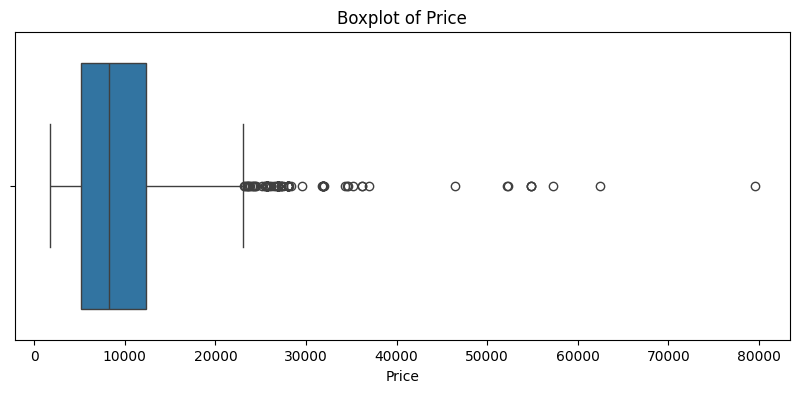

In [81]:
plt.figure(figsize=(10,4))
sns.boxplot(x=train['Price'])
plt.title('Boxplot of Price')
plt.xlabel('Price')
plt.show()

In [82]:
skewness = train['Price'].skew()
print(f"The skewness of the price distribution is: {skewness}")

The skewness of the price distribution is: 1.8574899082173875


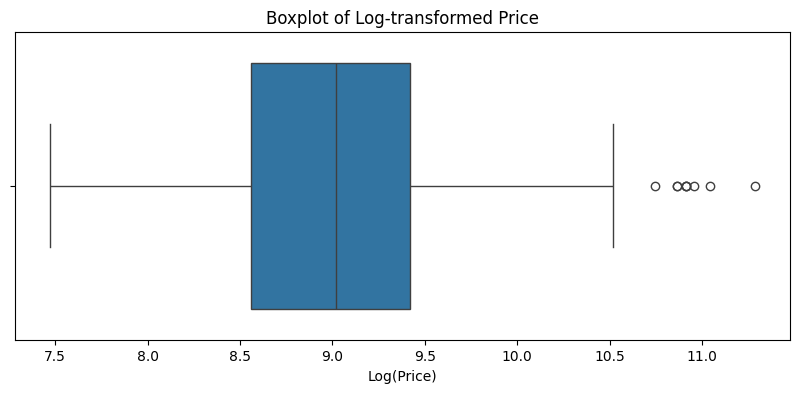

In [83]:
plt.figure(figsize=(10,4))
sns.boxplot(x=train['Price'].apply(lambda x: np.log(x+1)))
plt.title('Boxplot of Log-transformed Price')
plt.xlabel('Log(Price)')
plt.show()

In [84]:
from scipy.stats.mstats import winsorize

train['Log_Price'] = np.log1p(train['Price'])
train['Winsorized_Log_Price'] = winsorize(train['Log_Price'], limits=[0.05, 0.05])

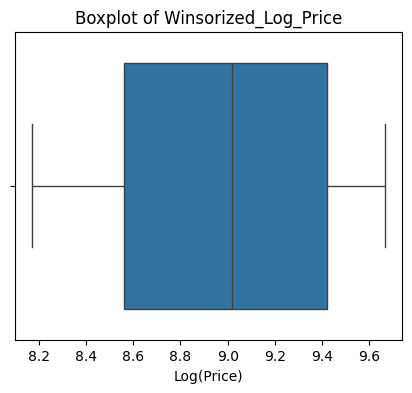

In [85]:
plt.figure(figsize=(5,4))
sns.boxplot(x=train['Winsorized_Log_Price'])
plt.title('Boxplot of Winsorized_Log_Price')
plt.xlabel('Log(Price)')
plt.show()

In [86]:
train_cols_drop = [
    'Date_of_Journey','Dep_Time','Arrival_Time','Date',
    'Arr_Time','Duration','Price','Log_Price','Winsorized_Log_Price'
]

test_cols_drop = [
    'Date_of_Journey','Dep_Time','Arrival_Time','Date',
    'Arr_Time','Duration','Year'
]

train = train.drop(train_cols_drop, axis=1)
test = test.drop(test_cols_drop, axis=1)

In [87]:
print("Observing the categorical column distribution before encoding:\n")

cols_cat = [
    'Airline','Source','Destination',
    'Total_Stops','Additional_Info','Departure','Arrival'
]

for columns in cols_cat:
    print(columns, "\n")
    print(train[columns].value_counts(), "\n")

Observing the categorical column distribution before encoding:

Airline 

Airline
Jet Airways          3700
IndiGo               2043
Air India            1694
Multiple carriers    1196
SpiceJet              815
Vistara               478
Air Asia              319
GoAir                 194
Others                 23
Name: count, dtype: int64 

Source 

Source
Delhi       4345
Kolkata     2860
Banglore    2179
Mumbai       697
Chennai      381
Name: count, dtype: int64 

Destination 

Destination
Cochin       4345
Banglore     2860
Delhi        2179
Hyderabad     697
Kolkata       381
Name: count, dtype: int64 

Total_Stops 

Total_Stops
1 stop      5625
non-stop    3475
2 stops     1318
3 stops       43
4 stops        1
Name: count, dtype: int64 

Additional_Info 

Additional_Info
No Info                         8185
In-flight meal not included     1926
No check-in baggage included     318
Other                             33
Name: count, dtype: int64 

Departure 

Departure
Morning     

In [88]:
train['Route'].value_counts()

,count
Route,
DEL → BOM → COK,2376
BLR → DEL,1536
CCU → BOM → BLR,979
CCU → BLR,724
BOM → HYD,621
...,...
BOM → VNS → DEL → HYD,1
BLR → HBX → BOM → NAG → DEL,1
BLR → BOM → IXC → DEL,1


In [89]:
route_counts = train['Route'].value_counts().to_dict()

train['Route_Frequency'] = train['Route'].map(route_counts)
test['Route_Frequency'] = test['Route'].map(route_counts)

train = train.drop('Route', axis=1)
test = test.drop('Route', axis=1)

In [90]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

for columns in cols_cat:
    train[columns] = encoder.fit_transform(train[columns])
    test[columns] = encoder.fit_transform(test[columns])

print("Observing the categorical column distribution after encoding:\n")
for columns in cols_cat:
    print(columns, "\n")
    print(train[columns].value_counts(), "\n")

Observing the categorical column distribution after encoding:

Airline 

Airline
4    3700
3    2043
1    1694
5    1196
7     815
8     478
0     319
2     194
6      23
Name: count, dtype: int64 

Source 

Source
2    4345
3    2860
0    2179
4     697
1     381
Name: count, dtype: int64 

Destination 

Destination
1    4345
0    2860
2    2179
3     697
4     381
Name: count, dtype: int64 

Total_Stops 

Total_Stops
0    5625
4    3475
1    1318
2      43
3       1
Name: count, dtype: int64 

Additional_Info 

Additional_Info
1    8185
0    1926
2     318
3      33
Name: count, dtype: int64 

Departure 

Departure
4    4224
0    2563
2    2123
1    1046
3     506
Name: count, dtype: int64 

Arrival 

Arrival
2    3142
0    2198
4    2193
1    1802
3    1127
Name: count, dtype: int64 



In [91]:
corr = train.corr()
print(corr)

                  Airline    Source  Destination  Total_Stops  \
Airline          1.000000 -0.007601     0.067356     0.028418   
Source          -0.007601  1.000000    -0.432609    -0.222859   
Destination      0.067356 -0.432609     1.000000     0.509297   
Total_Stops      0.028418 -0.222859     0.509297     1.000000   
Additional_Info  0.033858 -0.060359     0.140246     0.242391   
Departure        0.059864 -0.075116     0.039789    -0.027459   
Arrival         -0.025917 -0.011282     0.023784     0.039275   
Month            0.028988  0.181072    -0.149886    -0.021409   
Day              0.024765  0.005440     0.003571     0.030271   
Year                  NaN       NaN          NaN          NaN   
Dept_Hour       -0.018023  0.060218    -0.089073     0.040310   
Dept_Minute     -0.053672 -0.056609     0.096857     0.049338   
Arr_Hour        -0.019619  0.027646    -0.062195    -0.099230   
Arr_Min         -0.078308  0.020802     0.006637     0.176888   
Duration_Min    -0.148709

In [92]:
X = train.copy()
y = train.pop('Route_Frequency')

In [93]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [94]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

In [95]:
classifiers = [
    LinearRegression(),
    ElasticNet(),
    RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]),
    Lasso(alpha=16, random_state=100),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    SVR(),
    XGBRegressor()
]

In [96]:
name = []
score = []
models = []
rmse = []
r_2_score = []

for classifier in classifiers:
    classifier.fit(X_train, y_train)

    name.append(type(classifier).__name__)
    score.append(classifier.score(X_test, y_test))
    models.append(classifier)
    rmse.append(np.sqrt(mean_squared_error(classifier.predict(X_test), y_test)))
    r_2_score.append(r2_score(classifier.predict(X_test), y_test))

In [97]:
df_score = pd.DataFrame(
    list(zip(name, rmse, r_2_score, score, models)),
    columns=['name', 'rmse', 'r2_score', 'score', 'model']
)

df_score.set_index('name', inplace=True)
df_score.sort_values(by=['score'], inplace=True)
df_score

,rmse,r2_score,score,model
name,,,,
SVR,1.063559e+02,0.981081,0.984921,SVR()
AdaBoostRegressor,3.969948e+01,0.997893,0.997899,"(DecisionTreeRegressor(max_depth=3, random_sta..."
RidgeCV,1.365689e+00,0.999998,0.999998,"RidgeCV(alphas=[0.001, 0.01, 0.1, 1])"
GradientBoostingRegressor,2.266704e-01,1.000000,1.000000,([DecisionTreeRegressor(criterion='friedman_ms...
Lasso,1.886756e-02,1.000000,1.000000,"Lasso(alpha=16, random_state=100)"
RandomForestRegressor,4.223751e-03,1.000000,1.000000,"(DecisionTreeRegressor(max_features=1.0, rando..."
ElasticNet,1.179222e-03,1.000000,1.000000,ElasticNet()
LinearRegression,4.884503e-13,1.000000,1.000000,LinearRegression()
DecisionTreeRegressor,0.000000e+00,1.000000,1.000000,DecisionTreeRegressor()


In [98]:
best_model = df_score.iloc[-1]['model']
predict = best_model.predict(X_test)
predict[:10]

array([ 402.0012 ,  724.00006,  724.00024,  621.0004 , 1536.0001 ,
       2375.9998 , 2375.9998 ,  231.99762, 2375.9998 ,  212.99808],
      dtype=float32)

In [99]:
X_test['Prediction_Price'] = predict
X_test.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Departure,Arrival,Month,Day,Year,Dept_Hour,Dept_Minute,Arr_Hour,Arr_Min,Duration_Min,Route_Frequency,Prediction_Price
2150,4,0,2,0,1,4,4,3,6,2019,8,0,8,15,1455,402,402.001190
3784,7,3,0,4,1,3,1,6,6,2019,22,20,0,40,140,724,724.000061
714,3,3,0,4,1,1,4,3,18,2019,5,30,8,20,170,724,724.000244
7558,4,4,3,4,0,0,0,3,24,2019,15,50,17,20,90,621,621.000427
7413,7,0,2,4,1,4,0,4,27,2019,9,30,12,20,170,1536,1536.000122


In [100]:
X_test.to_csv("flight_price_predictions.csv", index=False)